<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_atlas_annotation_Seurat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of single-cell RNA-seq data: building and annotating an atlas
This notebook pre-processes the [pbmc_1k v3 dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3) from 10X Genomics with `kb` and then performs an analysis of the cell types and their marker genes.

The notebook was written by A. Sina Booeshaghi, Lambda Lu and Lior Pachter and is based on three noteboks:
- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Seurat [Guided Clustering Tutorial](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html).

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Stuart, Butler et al. Cell (2019). 


This notebook performs analysis of the pbmc_1k v3 dataset from 10X Genomics. It runs kb and then performs and analysis with Seurat.

## Setup

In [0]:
# This is  used to time the running of the notebook
start_time <- Sys.time()

### Install R packages

In [1]:
system.time({
  if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
  BiocManager::install(c('multtest', "DropletUtils"), Ncpus = 2)
  install.packages(c("Seurat", "scico"), Ncpus = 2)
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'multtest', 'DropletUtils'

also installing the dependencies ‘zlibbioc’, ‘bitops’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘formatR’, ‘GenomicRanges’, ‘GenomeInfoDb’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘SummarizedExperiment’, ‘futile.logger’, ‘snow’, ‘limma’, ‘locfit’, ‘DelayedArray’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘BiocGenerics’, ‘Biobase’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘Rhdf5lib’


Old packages: 'curl', 'DT', 'farver', 'jsonlite', 'knitr', 'mime', 'rprojroot',
  'xfun', 'xtable', 'nlme'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘numDeriv’, ‘TH.data’, ‘sandwich’, ‘lsei’, ‘bibtex’, ‘gbRd’, ‘sn’, ‘mvtnorm’, ‘p

    user   system  elapsed 
2253.054  193.107 1395.283 

In [51]:
install.packages("scico")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Install kb-python

In [3]:
# Install kb (includes installing kallisto and bustools)
system("pip3 install kb-python", intern=TRUE)

[1] "Collecting kb-python"                                                                                                                                                                 
 [2] "  Downloading https://files.pythonhosted.org/packages/62/c9/2e5b8fa2cd873a23ae1aeb128b33165d6a9387a2f56ea1fafec1d6d32477/kb_python-0.24.4-py3-none-any.whl (35.4MB)"                  
 [3] "Collecting loompy>=3.0.6"                                                                                                                                                             
 [4] "  Downloading https://files.pythonhosted.org/packages/36/52/74ed37ae5988522fbf87b856c67c4f80700e6452410b4cd80498c5f416f9/loompy-3.0.6.tar.gz (41kB)"                                  
 [5] "Collecting anndata>=0.6.22.post1"                                                                                                                                                     
 [6] "  Downloading https://files.pythonhosted.org/packages/5b/c8/5c594a95ba293433dfe1cf188075ccbabe495bf2d291be744974aca85ffc/anndata-0.7.1-py3-none-any.whl (97kB)"                       
 [7] "Requirement already satisfied: h5py in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (2.8.0)"                                                                
 [8] "Requirement already satisfied: numpy in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (1.17.5)"                                                              
 [9] "Requirement already satisfied: scipy in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (1.4.1)"                                                               
[10] "Requirement already satisfied: setuptools in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (45.1.0)"                                                         
[11] "Requirement already satisfied: numba in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (0.47.0)"                                                              
[12] "Requirement already satisfied: click in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (7.0)"                                                                 
[13] "Collecting numpy-groupies"                                                                                                                                                            
[14] "  Downloading https://files.pythonhosted.org/packages/57/ae/18217b57ba3e4bb8a44ecbfc161ed065f6d1b90c75d404bd6ba8d6f024e2/numpy_groupies-0.9.10.tar.gz (43kB)"                         
[15] "Requirement already satisfied: importlib-metadata>=0.7; python_version < \"3.8\" in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (1.5.0)"           
[16] "Requirement already satisfied: packaging in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (20.1)"                                                    
[17] "Requirement already satisfied: natsort in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (5.5.0)"                                                     
[18] "Requirement already satisfied: pandas>=0.23.0 in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (0.25.3)"                                             
[19] "Requirement already satisfied: six in /usr/local/lib/python3.6/dist-packages (from h5py->loompy>=3.0.6->kb-python) (1.12.0)"                                                          
[20] "Requirement already satisfied: llvmlite>=0.31.0dev0 in /usr/local/lib/python3.6/dist-packages (from numba->loompy>=3.0.6->kb-python) (0.31.0)"                                        
[21] "Requirement already satisfied: zipp>=0.5 in /usr/local/lib/python3.6/dist-packages (from importlib-metadata>=0.7; python_version < \"3.8\"->anndata>=0.6.22.post1->kb-python) (2.1.0)"
[22] "Requirement already satisf

### Download the data

In [4]:
# Download the data from the 10x website
system("wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar", intern=TRUE)
system("tar -xvf pbmc_1k_v3_fastqs.tar", intern=TRUE)

character(0)

[1] "pbmc_1k_v3_fastqs/"                                  
[2] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz"
[4] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz"
[5] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz"
[6] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz"
[7] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz"

### Download an index

In [5]:
system("kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta",intern=TRUE)

character(0)

## Pseudoalignment and counting

### Run kallisto and bustools

In [6]:
system("kb count -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz",intern=TRUE)

character(0)

## Basic QC

In [0]:
library(DropletUtils)
library(Seurat)
library(Matrix)
library(tidyverse)
library(scico)
theme_set(theme_bw())

In [8]:
list.files(".", recursive = TRUE)

[1] "index.idx"                                           
 [2] "output/10xv3_whitelist.txt"                          
 [3] "output/counts_filtered/cells_x_genes.barcodes.txt"   
 [4] "output/counts_filtered/cells_x_genes.genes.txt"      
 [5] "output/counts_filtered/cells_x_genes.mtx"            
 [6] "output/counts_unfiltered/cells_x_genes.barcodes.txt" 
 [7] "output/counts_unfiltered/cells_x_genes.genes.txt"    
 [8] "output/counts_unfiltered/cells_x_genes.mtx"          
 [9] "output/filter_barcodes.txt"                          
[10] "output/inspect.json"                                 
[11] "output/matrix.ec"                                    
[12] "output/output.bus"                                   
[13] "output/output.filtered.bus"                          
[14] "output/output.unfiltered.bus"                        
[15] "output/run_info.json"                                
[16] "output/transcripts.txt"                              
[17] "pbmc_1k_v3_fastqs.tar"                               
[18] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz"
[19] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz"
[20] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz"
[21] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz"
[22] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz"
[23] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz"
[24] "sample_data/anscombe.json"                           
[25] "sample_data/california_housing_test.csv"             
[26] "sample_data/california_housing_train.csv"            
[27] "sample_data/mnist_test.csv"                          
[28] "sample_data/mnist_train_small.csv"                   
[29] "sample_data/README.md"                               
[30] "t2g.txt"

In [0]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes")

In [4]:
dim(res_mat)

[1]  60623 259615

## Test for library saturation

In [0]:
tot_counts <- colSums(res_mat)
lib_sat <- tibble(nCount = tot_counts,
                  nGene = colSums(res_mat > 0))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


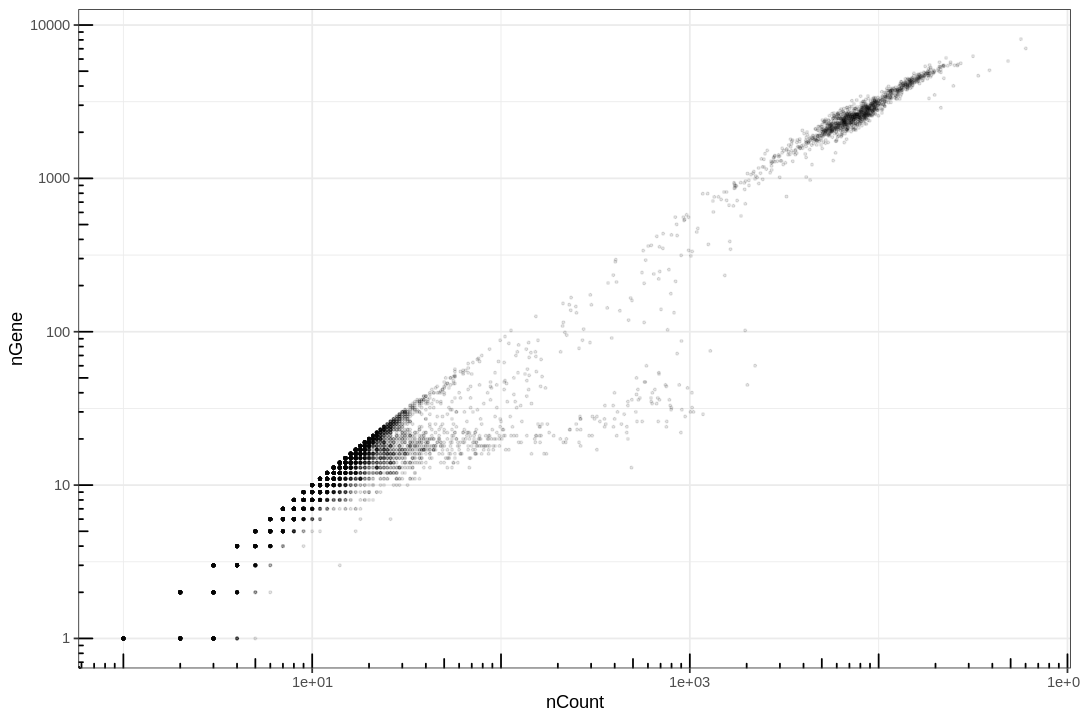

In [59]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(lib_sat, aes(nCount, nGene)) +
  geom_point(alpha = 0.1, size = 0.5) +
  scale_x_log10() + scale_y_log10() + annotation_logticks()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 19583 rows containing non-finite values (stat_bin2d).”


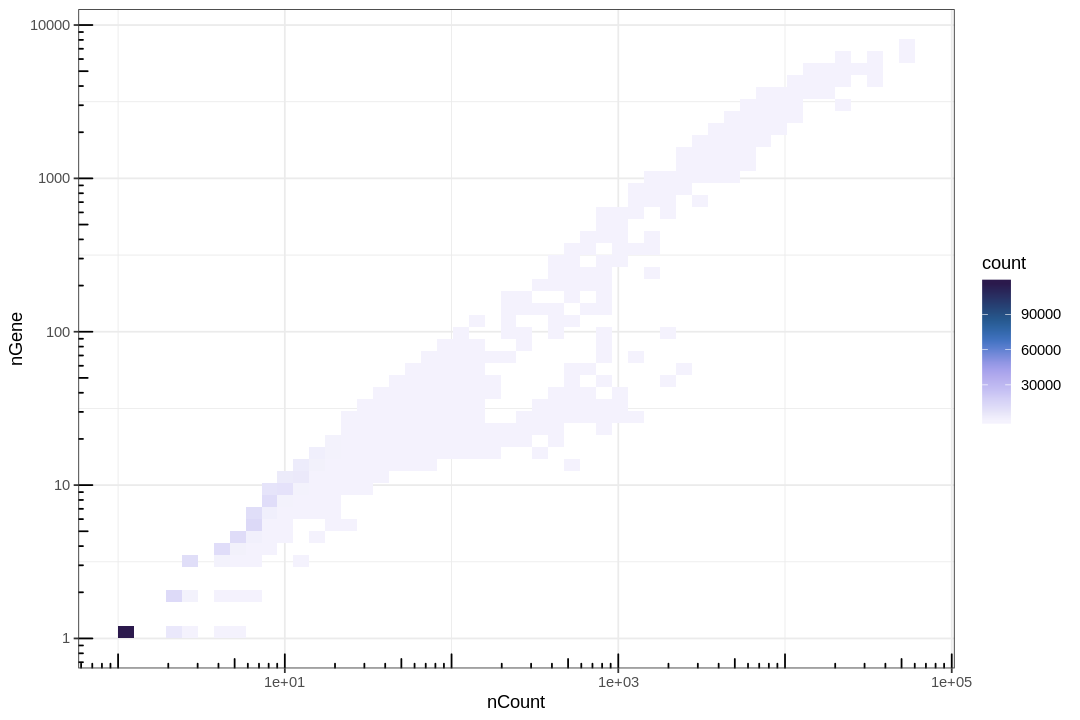

In [60]:
ggplot(lib_sat, aes(nCount, nGene)) +
  geom_bin2d(bins = 50) +
  scale_fill_scico(palette = "devon", direction = -1, end = 0.95) +
  scale_x_log10() + scale_y_log10() + annotation_logticks()

As we can see, lots of points are piled at around 1 gene and 1 count.

## Knee plot

In [8]:
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    43.64     6.00 60120.00 

In [0]:
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions. Will be added to the next release
#' version of BUSpaRse.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

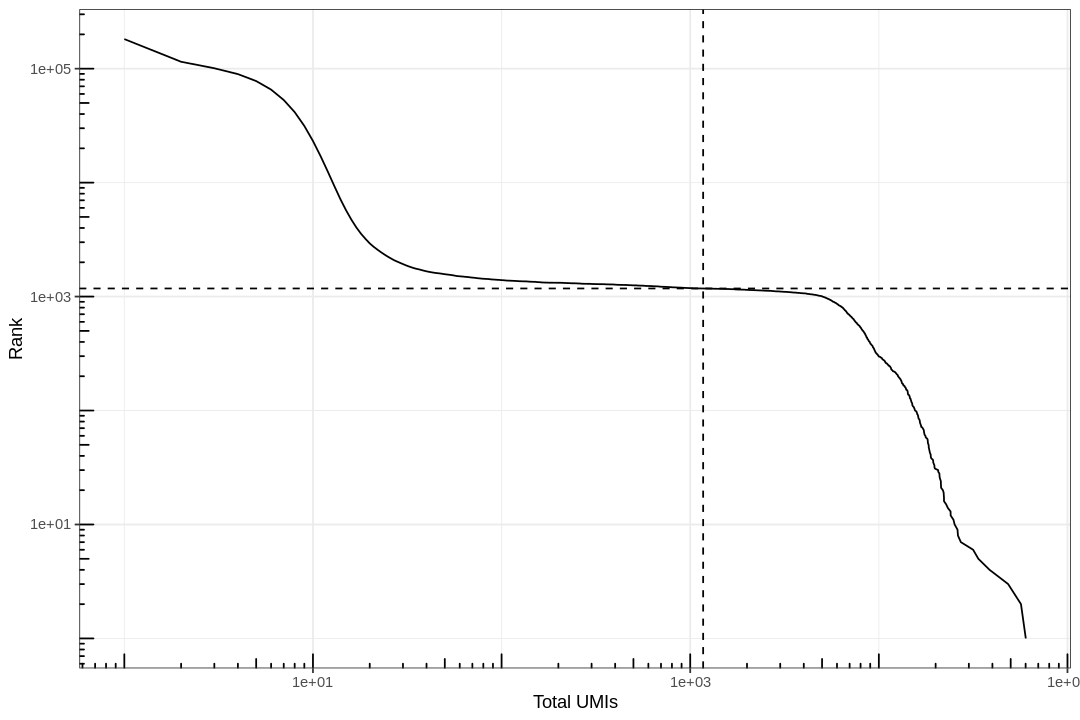

In [11]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

## Analysis

### Filter

In [12]:
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 31832  1178

In [13]:
head(rownames(res_mat))

[1] "ENSG00000223972.5" "ENSG00000238009.6" "ENSG00000233750.3"
[4] "ENSG00000268903.1" "ENSG00000241860.7" "ENSG00000241599.1"

In [14]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_name"))
tr2g <- distinct(tr2g[, c("gene", "gene_name")])

Parsed with column specification:
cols(
  transcript = col_character(),
  gene = col_character(),
  gene_name = col_character()
)



In [0]:
mt_genes <- tr2g$gene[str_detect(tr2g$gene_name, "^MT-")]

In [0]:
#system("wget https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz",intern=TRUE);
#system("gunzip pbmc3k_filtered_gene_bc_matrices.tar.gz", intern=TRUE);
#system("tar -xvf pbmc3k_filtered_gene_bc_matrices.tar", intern=TRUE)
#system("cp filtered_gene_bc_matrices/hg19/* .",intern=TRUE)

In [17]:
(pbmc <- CreateSeuratObject(counts = res_mat, project = "pbmc1k", min.cells = 3, min.features = 200))

An object of class Seurat 
25950 features across 1173 samples within 1 assay 
Active assay: RNA (25950 features)

The . values in the matrix represent 0s (no molecules detected). Since most values in an scRNA-seq matrix are 0, Seurat uses a sparse-matrix representation whenever possible. This results in significant memory and speed savings for Drop-seq/inDrop/10x data.

In [18]:
(dense.size <- object.size(as.matrix(res_mat)))

302890136 bytes

In [19]:
(sparse.size <- object.size(res_mat))

41703272 bytes

In [20]:
as.numeric(dense.size/sparse.size)

[1] 7.262983

Standard pre-processing workflow
The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features.

QC and selecting cells for further analysis
Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. A few QC metrics commonly used by the community include

The number of unique genes detected in each cell.
Low-quality cells or empty droplets will often have very few genes
Cell doublets or multiplets may exhibit an aberrantly high gene count
Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
The percentage of reads that map to the mitochondrial genome
Low-quality / dying cells often exhibit extensive mitochondrial contamination
We calculate mitochondrial QC metrics with the PercentageFeatureSet function, which calculates the percentage of counts originating from a set of features
We use the set of all genes starting with MT- as a set of mitochondrial genes

In [0]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, features = mt_genes)

The number of unique genes and total molecules are automatically calculated during CreateSeuratObject
You can find them stored in the object meta data


In [22]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGGAGAGTA,pbmc1k,9289,3198,11.271396
AAACGCTTCAGCCCAG,pbmc1k,6483,2513,8.252352
AAAGAACAGACGACTG,pbmc1k,5011,2082,6.166434
AAAGAACCAATGGCAG,pbmc1k,3264,1555,6.893382
AAAGAACGTCTGCAAT,pbmc1k,7488,2508,6.610577


In the example below, we visualize QC metrics, and use these to filter cells.

We filter cells that have unique feature counts over 2,500 or less than 200
We filter cells that have >5% mitochondrial counts

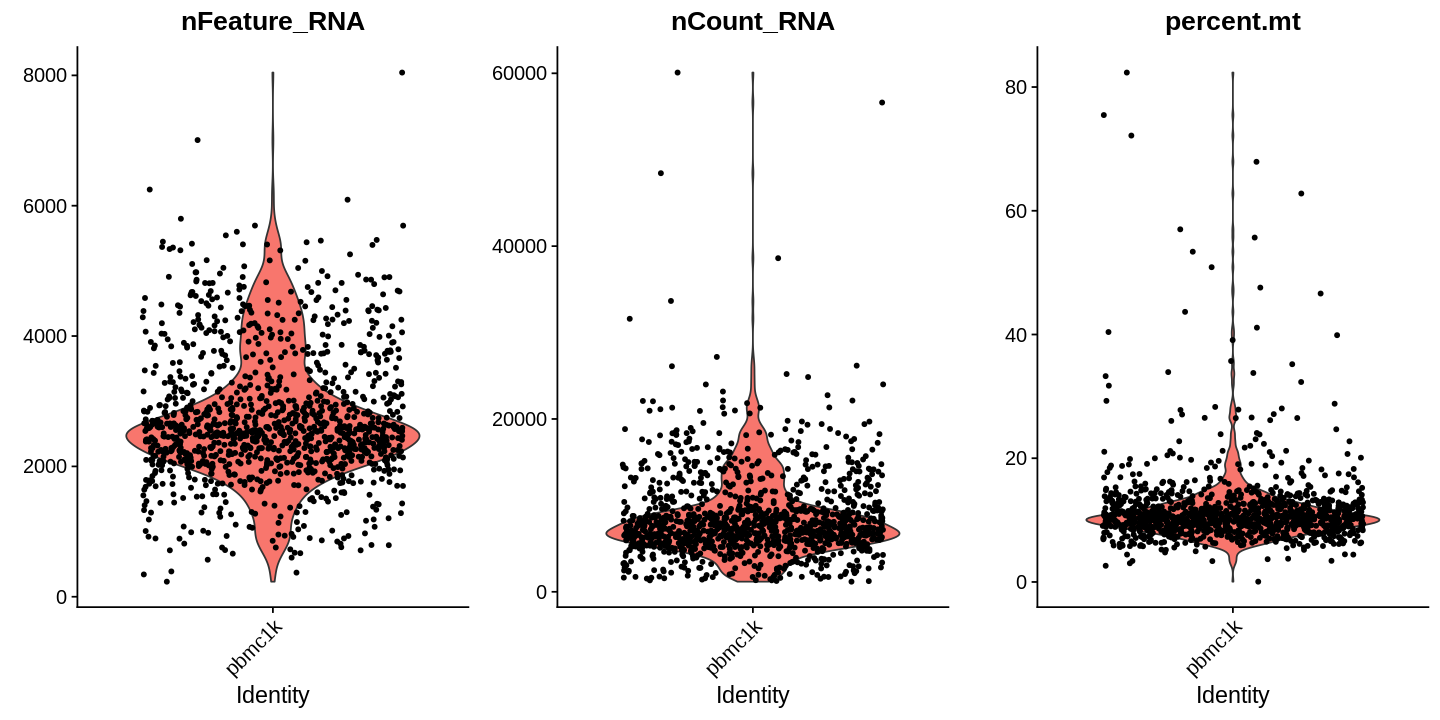

In [23]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=12, repr.plot.height=6)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

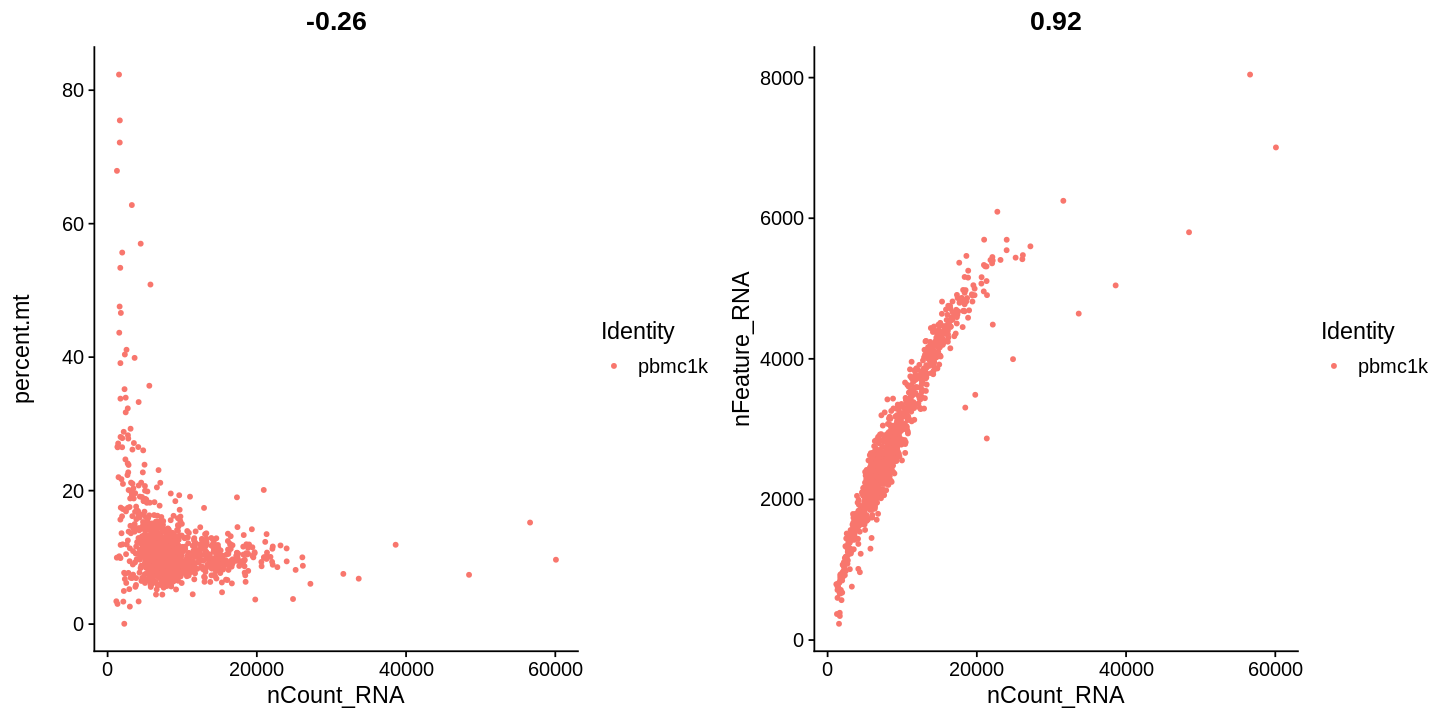

In [24]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

Normalizing the data
After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in pbmc[["RNA"]]@data.

In [0]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 6500 & percent.mt < 20)

### Normalize counts

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in pbmc[["RNA"]]@data.

In [0]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

For clarity, in this previous line of code (and in future commands), we provide the default values for certain parameters in the function call. However, this isn’t required and the same behavior can be achieved with:

In [0]:
# pbmc <- NormalizeData(pbmc)

What are the most highly expressed genes?

In [0]:
gs <- rownames(res_mat)[order(-rowSums(res_mat))]
df <- as.data.frame(t(GetAssayData(pbmc, slot = "counts")[gs[1:20],]))
df <- df %>%
  mutate_all(function(x) x/pbmc$nCount_RNA)

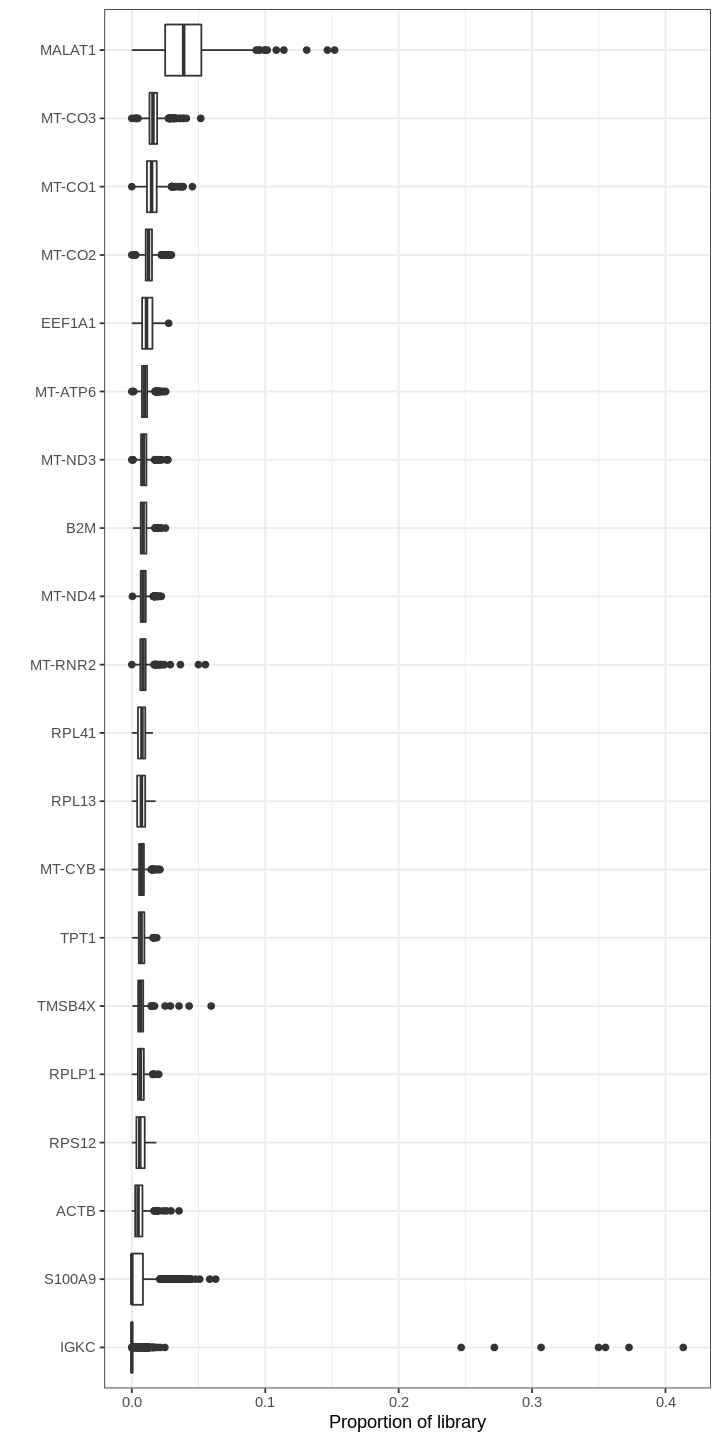

In [54]:
options(repr.plot.width=6, repr.plot.height=12)
df %>%
  pivot_longer(everything(), names_to = "gene") %>%
  left_join(tr2g, by = "gene") %>%
  mutate(gene = fct_reorder(gene_name, value, .fun = median)) %>%
  ggplot(aes(gene, value)) +
  geom_boxplot() +
  labs(x = "", y = "Proportion of library") +
  coord_flip()

# Identification of highly variable features (feature selection)
We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We and others have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

Our procedure in Seurat3 is described in detail here, and improves on previous versions by directly modeling the mean-variance relationship inherent in single-cell data, and is implemented in the FindVariableFeatures function. By default, we return 2,000 features per dataset. These will be used in downstream analysis, like PCA.

When using repel, set xnudge and ynudge to 0 for optimal results



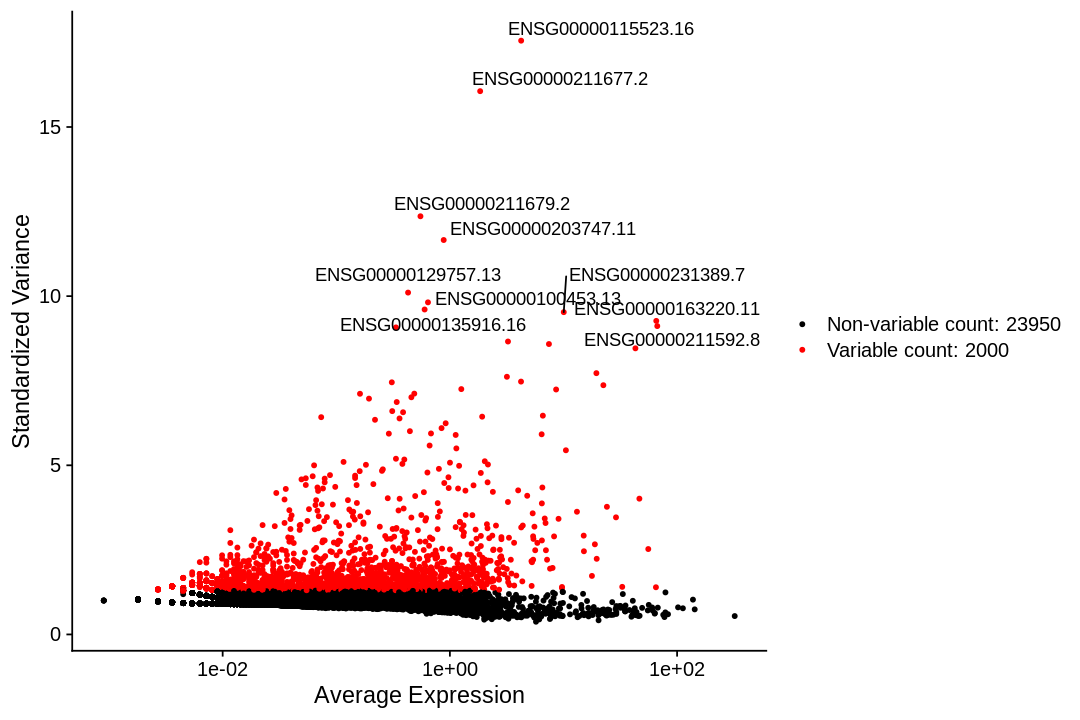

In [35]:
options(repr.plot.width=9, repr.plot.height=6)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

#Scaling the data
Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The ScaleData function:

Shifts the expression of each gene, so that the mean expression across cells is 0
Scales the expression of each gene, so that the variance across cells is 1
This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
The results of this are stored in pbmc[["RNA"]]@scale.data

In [36]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



Scaling is an essential step in the Seurat workflow, but only on genes that will be used as input to PCA. Therefore, the default in ScaleData is only to perform scaling on the previously identified variable features (2,000 by default). To do this, omit the features argument in the previous function call, i.e

In [0]:
# pbmc <- ScaleData(pbmc)


Centering and scaling data matrix



Your PCA and clustering results will be unaffected. However, Seurat heatmaps (produced as shown below with DoHeatmap) require genes in the heatmap to be scaled, to make sure highly-expressed genes don’t dominate the heatmap. To make sure we don’t leave any genes out of the heatmap later, we are scaling all genes in this tutorial.



In Seurat v2 we also use the ScaleData function to remove unwanted sources of variation from a single-cell dataset. For example, we could ‘regress out’ heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination. These features are still supported in ScaleData in Seurat v3, i.e.:

In [0]:
# pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



However, particularly for advanced users who would like to use this functionality, we strongly recommend the use of our new normalization workflow, sctransform. The method is described in our recent preprint, with a separate vignette using Seurat v3 here. As with ScaleData, the function SCTransform also includes a vars.to.regress parameter.



### Principal component analysis

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset.

In [37]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  ENSG00000163220.11, ENSG00000085265.11, ENSG00000163563.8, ENSG00000101439.9, ENSG00000127951.7, ENSG00000090382.6, ENSG00000143546.10, ENSG00000163131.11, ENSG00000116701.14, ENSG00000197249.13 
	   ENSG00000197746.14, ENSG00000204472.13, ENSG00000025708.14, ENSG00000038427.16, ENSG00000121552.4, ENSG00000136826.15, ENSG00000030582.18, ENSG00000197629.6, ENSG00000106066.15, ENSG00000110077.14 
	   ENSG00000172243.17, ENSG00000204482.10, ENSG00000185215.9, ENSG00000158869.11, ENSG00000170458.14, ENSG00000165168.7, ENSG00000100097.12, ENSG00000163221.9, ENSG00000011600.11, ENSG00000135218.19 
Negative:  ENSG00000227507.2, ENSG00000277734.8, ENSG00000198851.9, ENSG00000211772.11, ENSG00000167286.9, ENSG00000008517.16, ENSG00000127152.18, ENSG00000160654.10, ENSG00000168685.15, ENSG00000081059.20 
	   ENSG00000110848.8, ENSG00000172183.15, ENSG00000198821.10, ENSG00000139193.3, ENSG00000107742.13, ENSG00000188042.8, ENSG00000173762.8, ENSG00000116824.5, ENSG00000197540.8

Seurat provides several useful ways of visualizing both cells and features that define the PCA, including VizDimReduction, DimPlot, and DimHeatmap



In [38]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  ENSG00000163220.11, ENSG00000085265.11, ENSG00000163563.8, ENSG00000101439.9, ENSG00000127951.7 
Negative:  ENSG00000227507.2, ENSG00000277734.8, ENSG00000198851.9, ENSG00000211772.11, ENSG00000167286.9 
PC_ 2 
Positive:  ENSG00000198851.9, ENSG00000008517.16, ENSG00000198821.10, ENSG00000197540.8, ENSG00000173762.8 
Negative:  ENSG00000105369.9, ENSG00000156738.17, ENSG00000211899.10, ENSG00000153064.12, ENSG00000119866.22 
PC_ 3 
Positive:  ENSG00000005249.13, ENSG00000168497.5, ENSG00000127920.6, ENSG00000163736.4, ENSG00000163737.4 
Negative:  ENSG00000170345.10, ENSG00000120129.6, ENSG00000026025.16, ENSG00000245532.9, ENSG00000185862.7 
PC_ 4 
Positive:  ENSG00000138795.10, ENSG00000081059.20, ENSG00000168685.15, ENSG00000172005.11, ENSG00000126353.3 
Negative:  ENSG00000100453.13, ENSG00000115523.16, ENSG00000105374.10, ENSG00000169583.13, ENSG00000150045.12 
PC_ 5 
Positive:  ENSG00000115523.16, ENSG00000137441.8, ENSG00000150045.12, ENSG00000180644.8, ENSG000

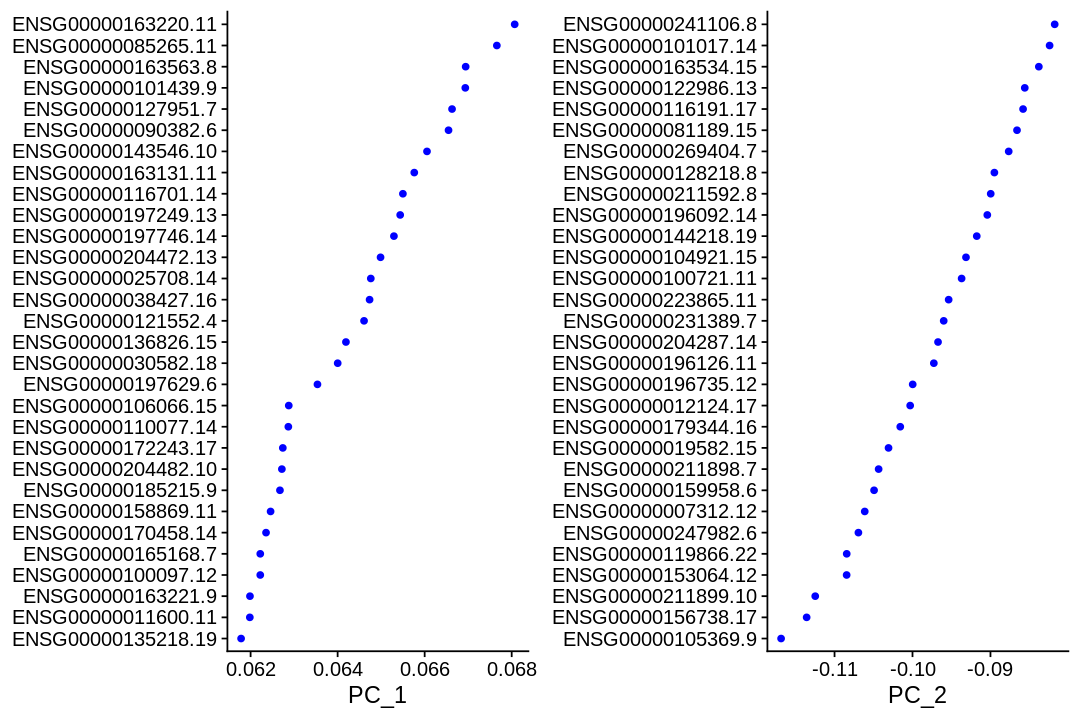

In [39]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

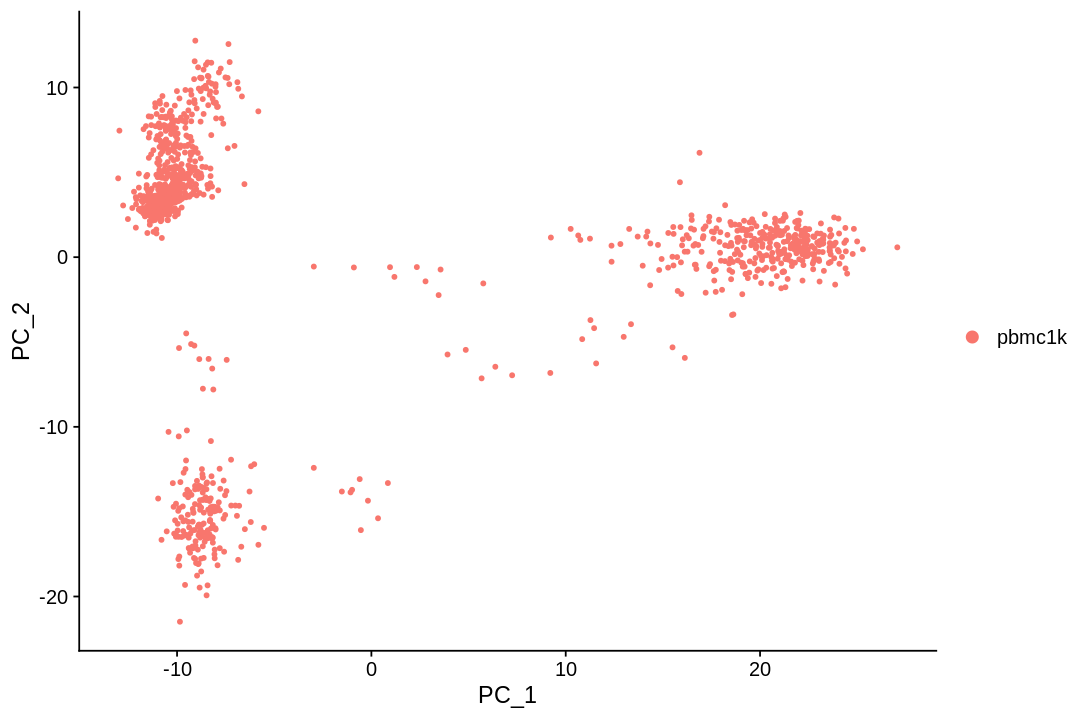

In [40]:
options(repr.plot.width=9, repr.plot.height=6)
DimPlot(pbmc, reduction = "pca")

In particular DimHeatmap allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting cells to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.

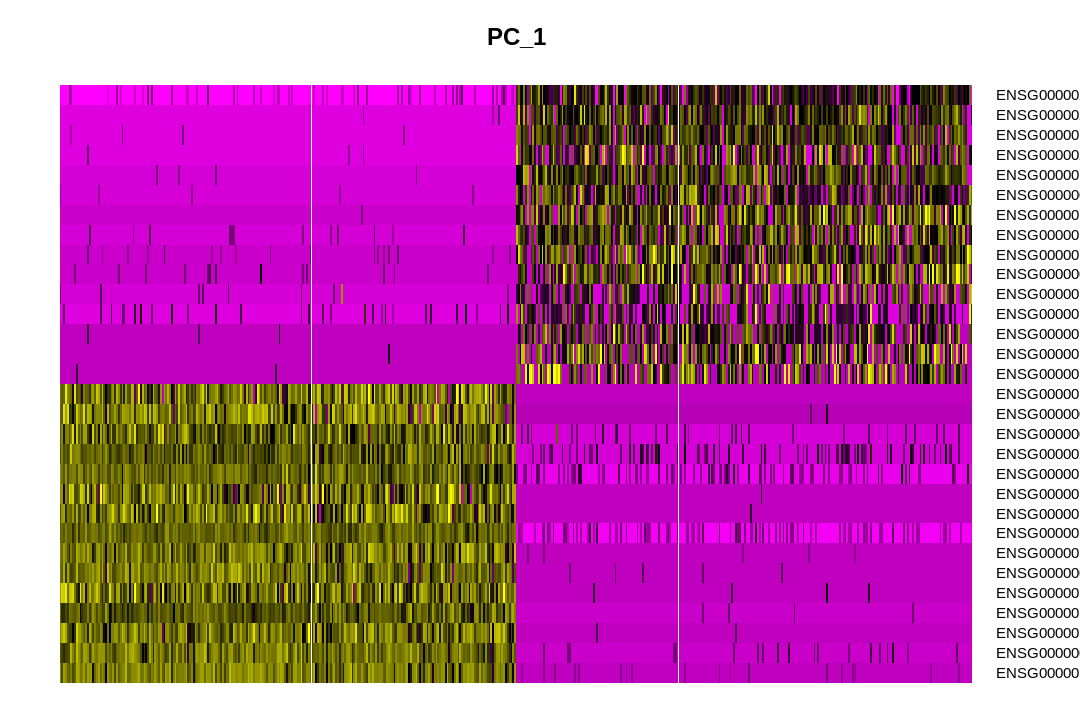

In [41]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

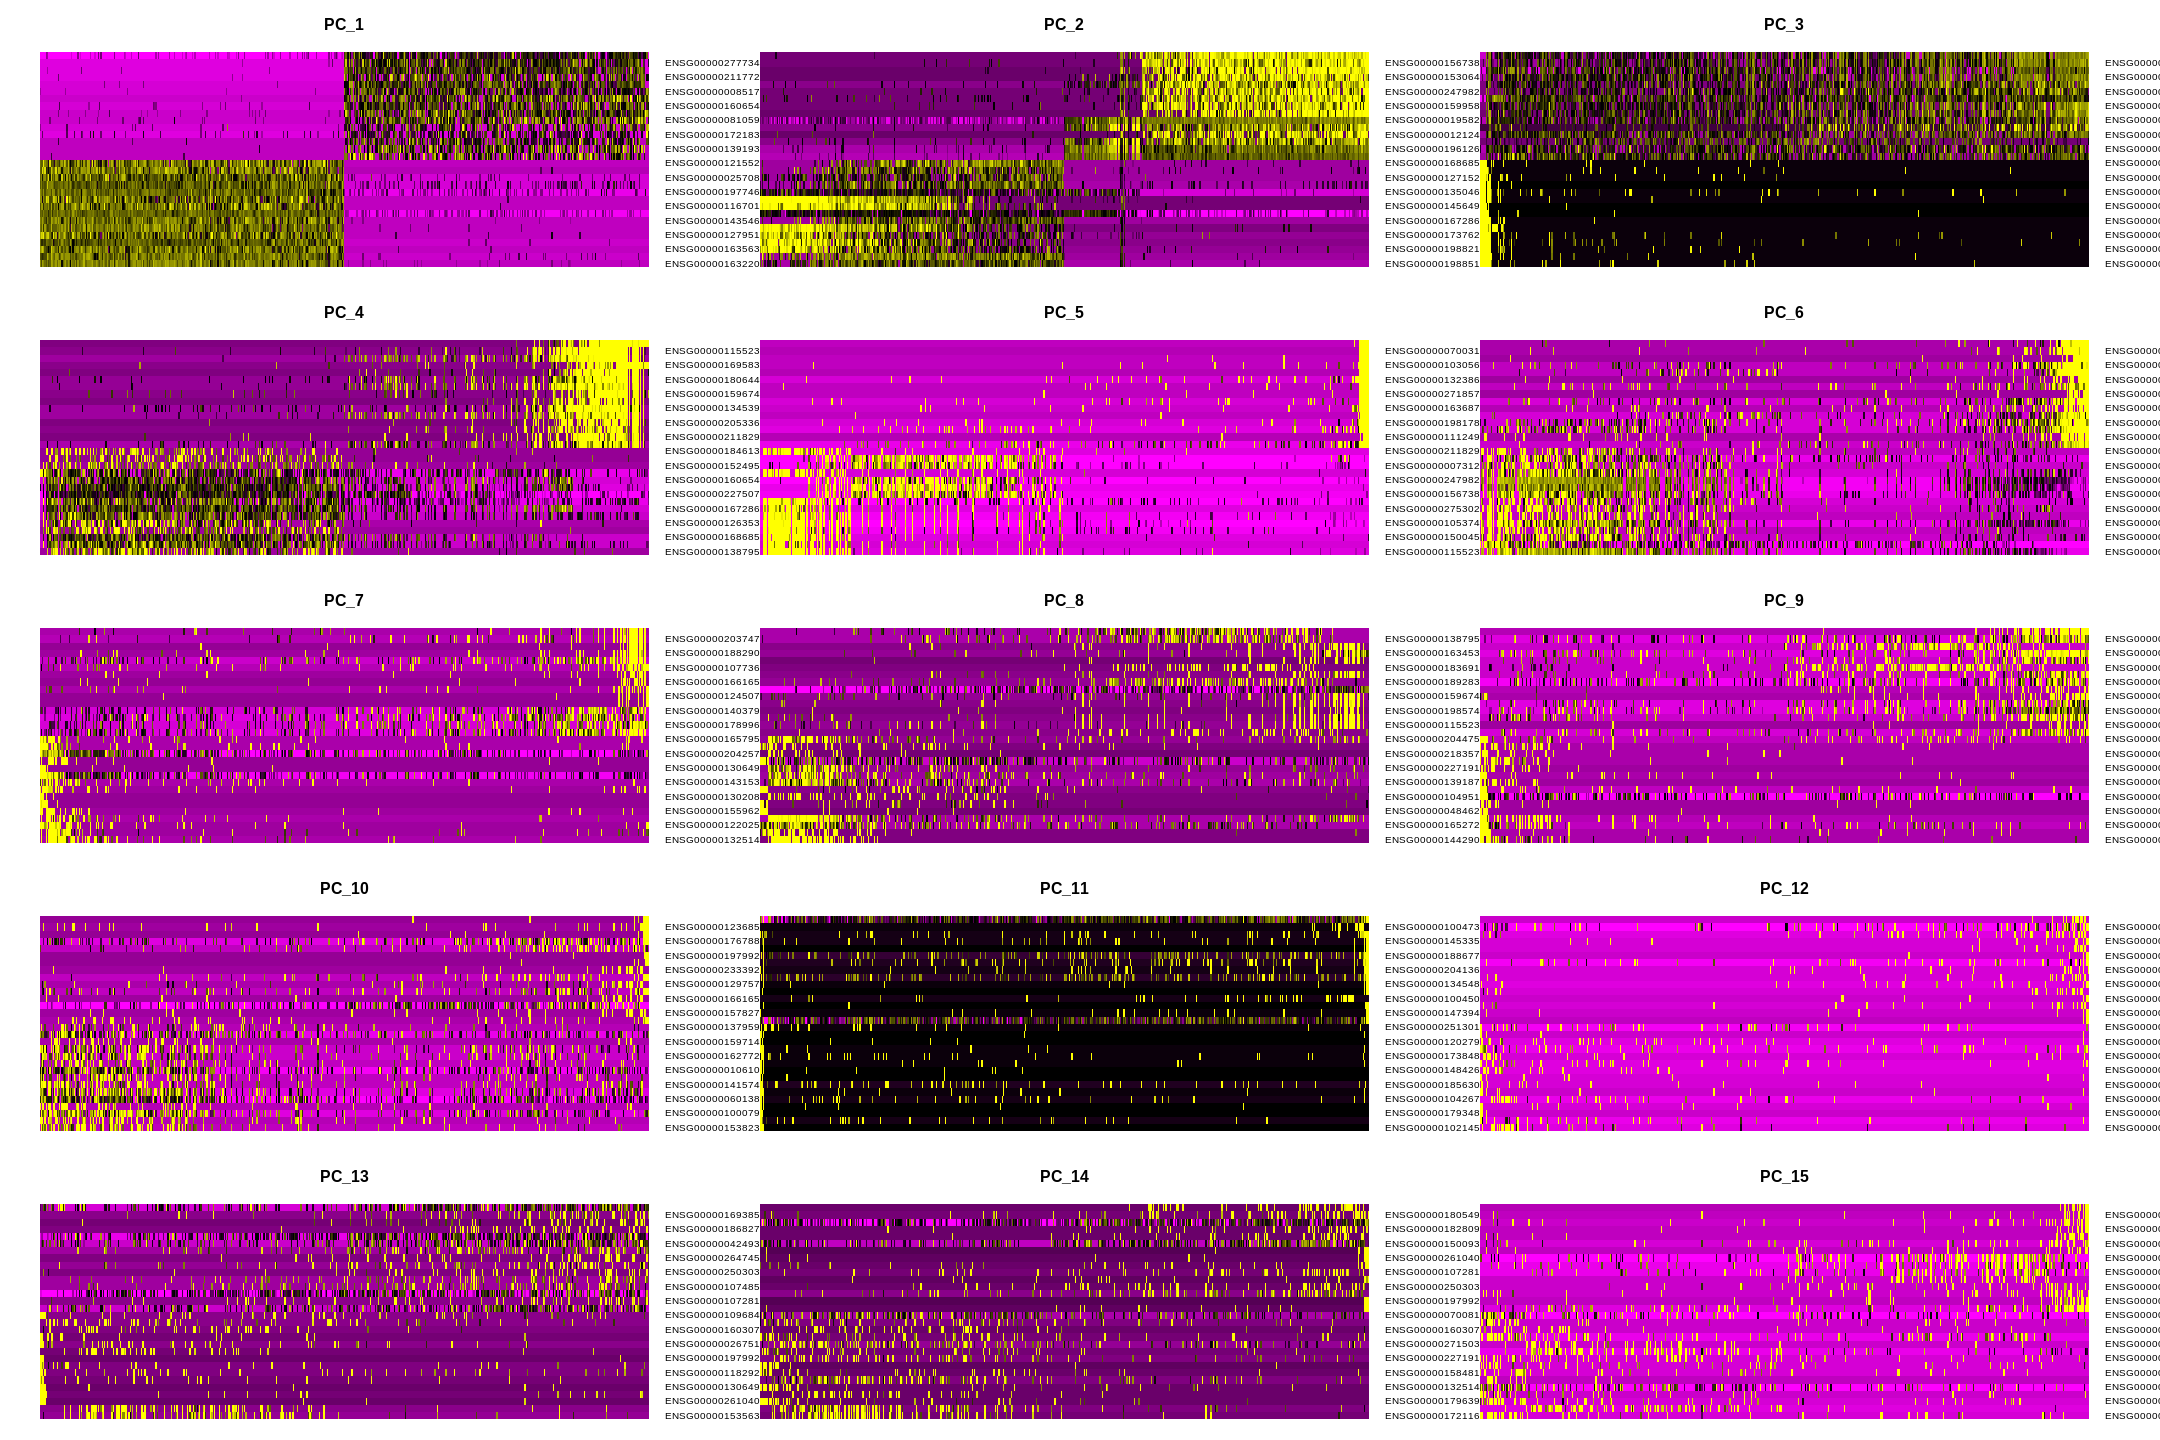

In [42]:
options(repr.plot.width=18, repr.plot.height=12)
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

# Determine the ‘dimensionality’ of the dataset
To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a ‘metafeature’ that combines information across a correlated feature set. The top principal components therefore represent a robust compression of the dataset. However, how many componenets should we choose to include? 10? 20? 100?

In Macosko et al, we implemented a resampling test inspired by the JackStraw procedure. We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a ‘null distribution’ of feature scores, and repeat this procedure. We identify ‘significant’ PCs as those who have a strong enrichment of low p-value features.

In [0]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

The JackStrawPlot function provides a visualization tool for comparing the distribution of p-values for each PC with a uniform distribution (dashed line). ‘Significant’ PCs will show a strong enrichment of features with low p-values (solid curve above the dashed line). In this case it appears that there is a sharp drop-off in significance after the first 10-12 PCs.

Warning message:
“Removed 30880 rows containing missing values (geom_point).”


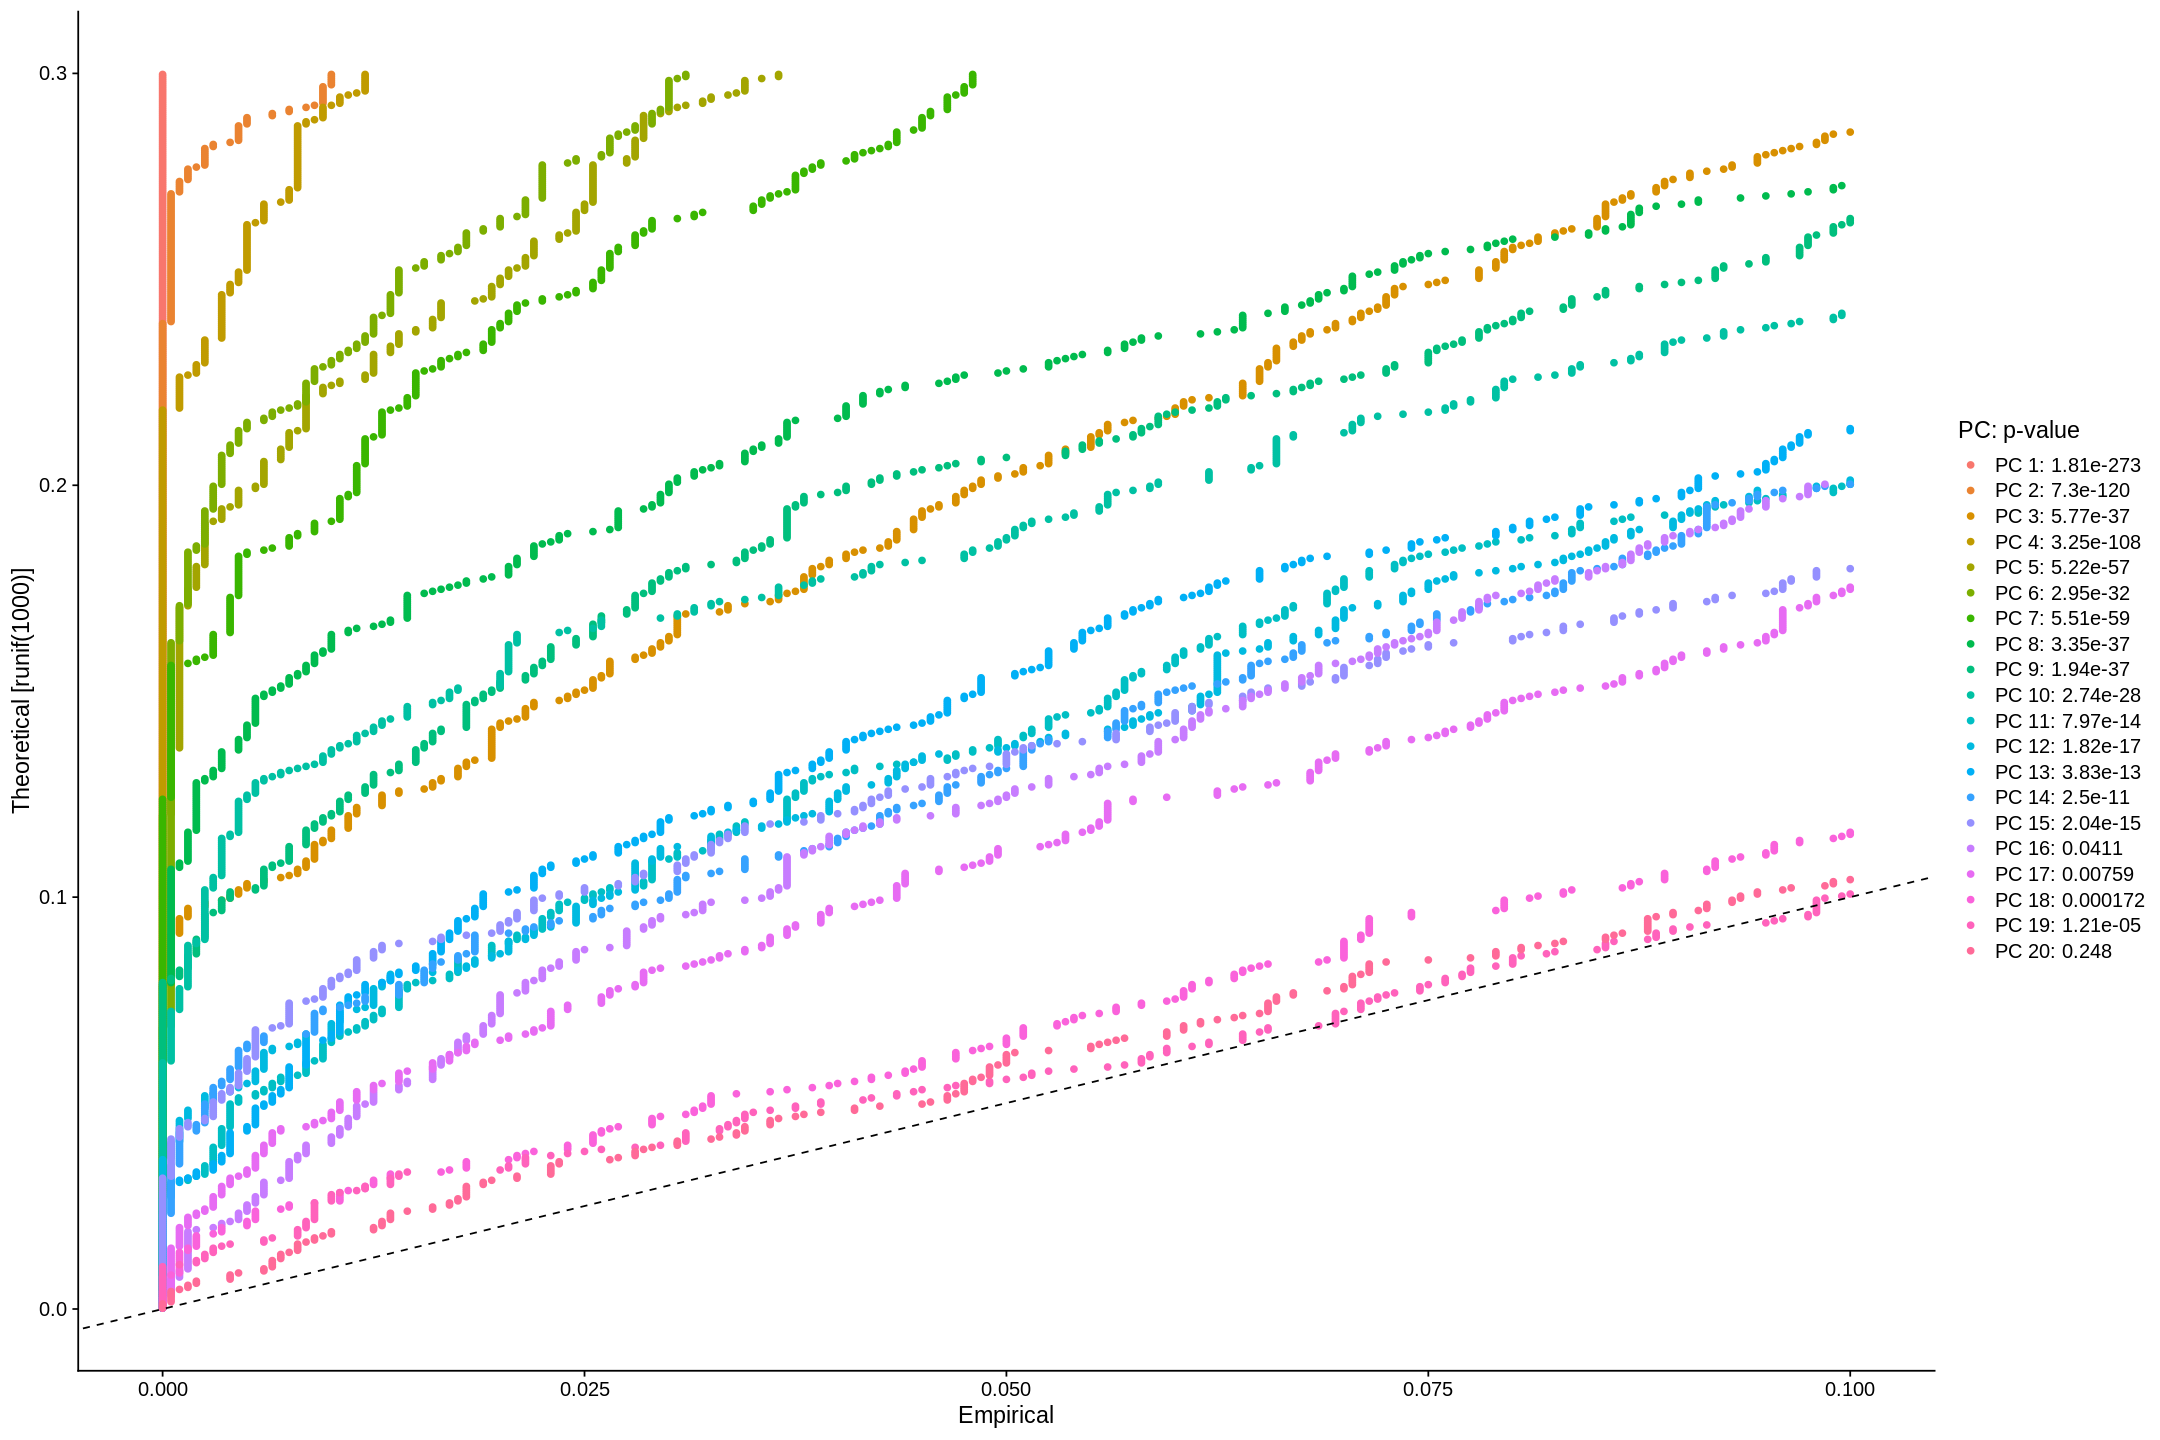

In [44]:
JackStrawPlot(pbmc, dims = 1:20)

An alternative heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot function). In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

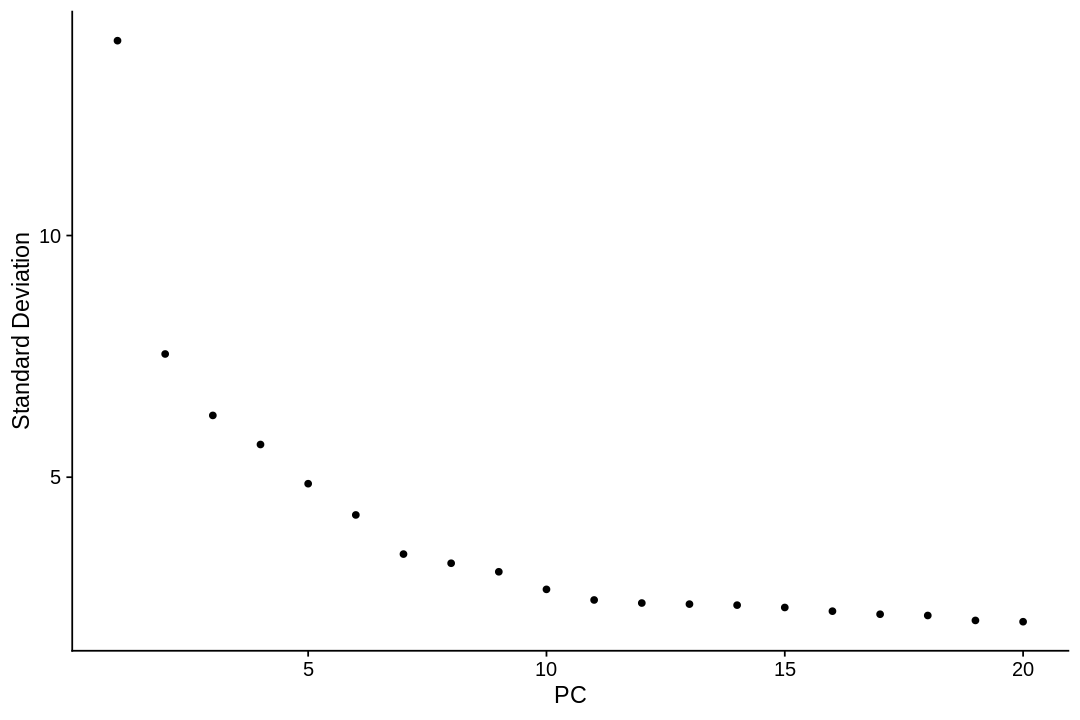

In [45]:
options(repr.plot.width=9, repr.plot.height=6)
ElbowPlot(pbmc)

Identifying the true dimensionality of a dataset – can be challenging/uncertain for the user. We therefore suggest these three approaches to consider. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. The third is a heuristic that is commonly used, and can be calculated instantly. In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-12 as a cutoff.

We chose 10 here, but encourage users to consider the following:

Dendritic cell and NK aficionados may recognize that genes strongly associated with PCs 12 and 13 define rare immune subsets (i.e. MZB1 is a marker for plasmacytoid DCs). However, these groups are so rare, they are difficult to distinguish from background noise for a dataset of this size without prior knowledge.
We encourage users to repeat downstream analyses with a different number of PCs (10, 15, or even 50!). As you will observe, the results often do not differ dramatically.
We advise users to err on the higher side when choosing this parameter. For example, performing downstream analyses with only 5 PCs does signifcanltly and adversely affect results.

### Computer the neighborhood graph

Cluster the cells
Seurat v3 applies a graph-based clustering approach, building upon initial strategies in (Macosko et al). Importantly, the distance metric which drives the clustering analysis (based on previously identified PCs) remains the same. However, our approach to partioning the cellular distance matrix into clusters has dramatically improved. Our approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [SNN-Cliq, Xu and Su, Bioinformatics, 2015] and CyTOF data [PhenoGraph, Levine et al., Cell, 2015]. Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’.

As in PhenoGraph, we first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the FindNeighbors function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).

To cluster the cells, we next apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics], to iteratively group cells together, with the goal of optimizing the standard modularity function. The FindClusters function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the Idents function.

In [46]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1113
Number of edges: 36080

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8903
Number of communities: 8
Elapsed time: 0 seconds


In [47]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACCCAAGGAGAGTA AAACGCTTCAGCCCAG AAAGAACAGACGACTG AAAGAACCAATGGCAG 
               1                4                5                5 
AAAGAACGTCTGCAAT 
               0 
Levels: 0 1 2 3 4 5 6 7

# Run non-linear dimensional reduction (UMAP/tSNE)
Seurat offers several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets. The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. As input to the UMAP and tSNE, we suggest using the same PCs as input to the clustering analysis.

In [48]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:50:11 UMAP embedding parameters a = 0.9922 b = 1.112

21:50:11 Read 1113 rows and found 10 numeric columns

21:50:11 Using Annoy for neighbor search, n_neighbors = 30

21:50:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:50:12 Writing NN index file to temp file /tmp/RtmpggsmPT/file76eb4df6c4b0

21:50:12 Searching Annoy index using 1 thread, search_k = 3000

21:50:12 Annoy recall = 100%

21:50:13 Commencing smooth kNN distance calibration using 1 thread

21:50:15 Initializing fr

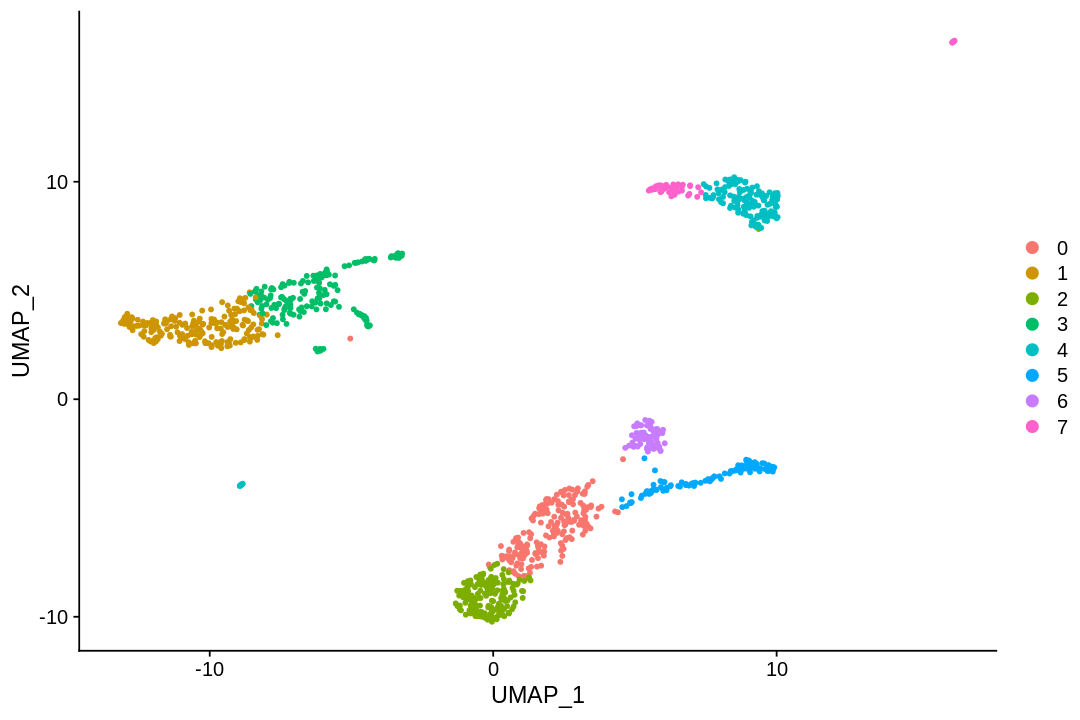

In [61]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

You can save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above, or easily shared with collaborators

# Finding differentially expressed features (cluster biomarkers)
Seurat can help you find markers that define clusters via differential expression. By default, it identifes positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. FindAllMarkers automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed features will likely still rise to the top.

In [62]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000163221.9,3.051669e-150,2.528048,0.985,0.143,7.919081e-146
ENSG00000143546.10,1.456759e-144,3.061867,1.000,0.204,3.780289e-140
ENSG00000038427.16,5.648779e-137,2.020143,0.995,0.168,1.465858e-132
ENSG00000163563.8,9.114225e-129,1.831347,1.000,0.193,2.365141e-124
ENSG00000163220.11,9.670845e-129,2.606748,1.000,0.257,2.509584e-124


In [64]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000077984.6,1.202638e-78,2.285326,0.954,0.089,3.120846e-74
ENSG00000145649.8,2.462088e-75,2.385995,0.963,0.108,6.389118e-71
ENSG00000105374.10,8.086374e-75,3.451195,0.982,0.156,2.098414e-70
ENSG00000180644.8,2.605438e-68,2.254622,0.872,0.086,6.761111e-64
ENSG00000172543.8,6.501505e-67,2.122803,1.000,0.253,1.687140e-62


In [65]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7



p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.338445e-67,1.239685,0.929,0.321,3.473264e-63,0,ENSG00000168685.15
3.059808e-65,1.081038,0.980,0.324,7.940203e-61,0,ENSG00000008517.16
1.456759e-144,3.061867,1.000,0.204,3.780289e-140,1,ENSG00000143546.10
9.670845e-129,2.606748,1.000,0.257,2.509584e-124,1,ENSG00000163220.11
8.493905e-62,1.004950,0.920,0.330,2.204168e-57,2,ENSG00000081059.20
2.190559e-61,1.005661,0.943,0.319,5.684500e-57,2,ENSG00000127152.18
5.109823e-94,1.692271,0.994,0.235,1.325999e-89,3,ENSG00000101439.9
1.829155e-50,1.626524,0.713,0.155,4.746658e-46,3,ENSG00000154146.13
1.805419e-192,3.226208,1.000,0.040,4.685063e-188,4,ENSG00000211899.10


Seurat has several tests for differential expression which can be set with the test.use parameter (see our DE vignette for details). For example, the ROC test returns the ‘classification power’ for any individual marker (ranging from 0 - random, to 1 - perfect).

In [0]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

We include several tools for visualizing marker expression. VlnPlot (shows expression probability distributions across clusters), and FeaturePlot (visualizes feature expression on a tSNE or PCA plot) are our most commonly used visualizations. We also suggest exploring RidgePlot, CellScatter, and DotPlot as additional methods to view your dataset.



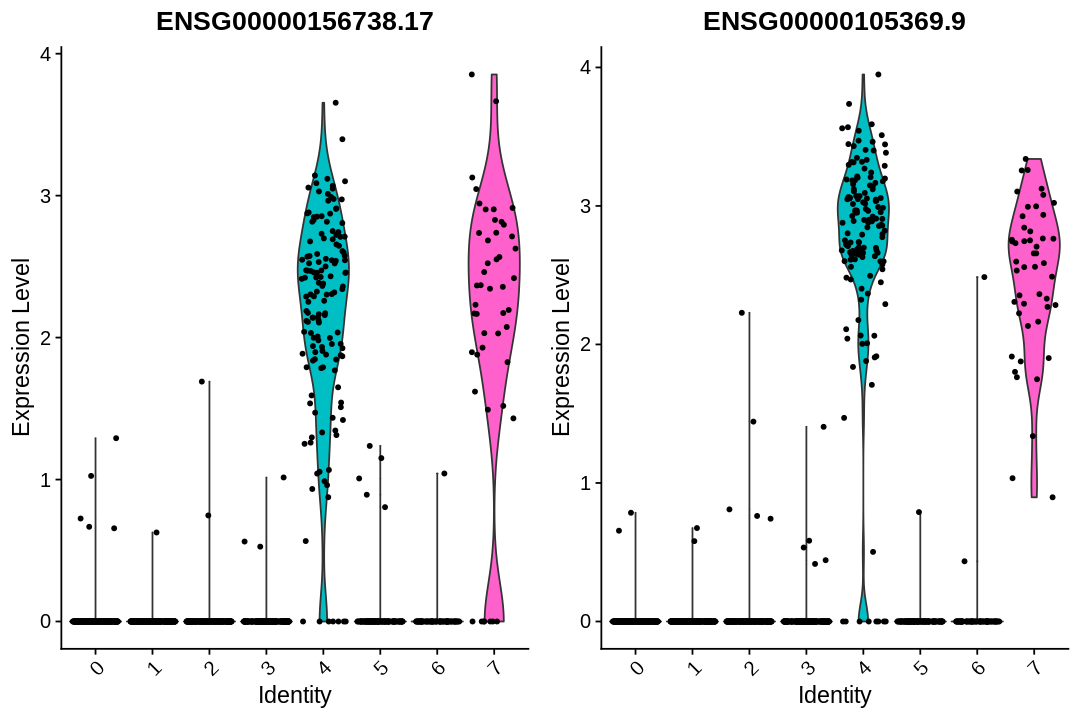

In [67]:
VlnPlot(pbmc, features = tr2g$gene[tr2g$gene_name %in% c("MS4A1", "CD79A")])

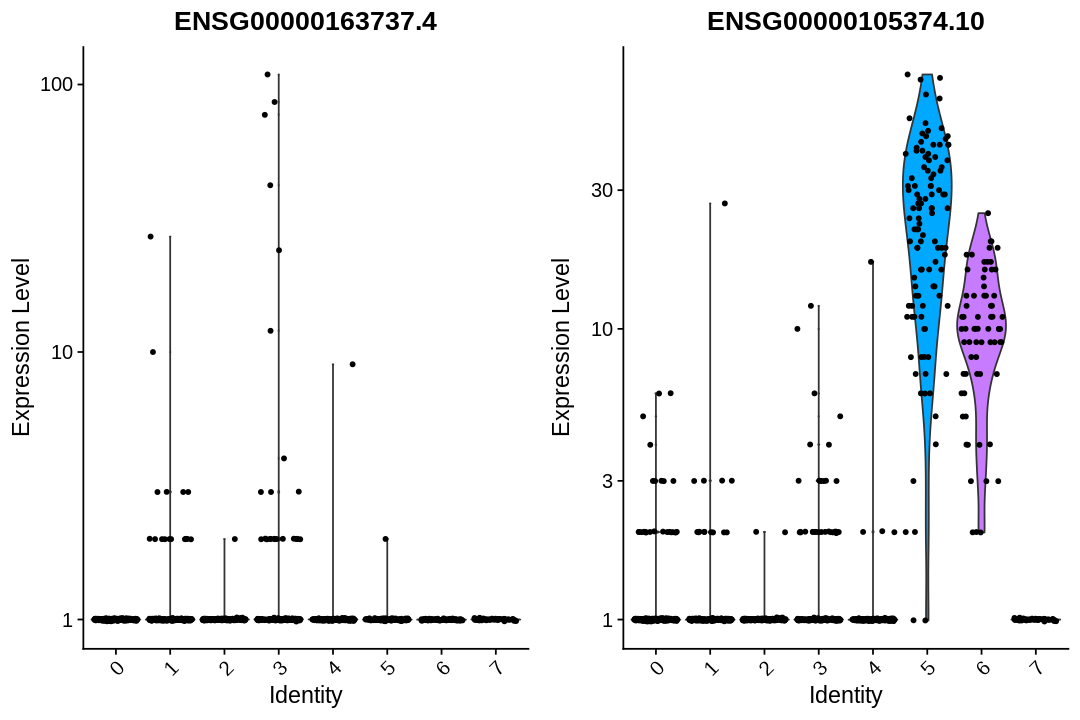

In [68]:
# you can plot raw counts as well
VlnPlot(pbmc, features = tr2g$gene[tr2g$gene_name %in% c("NKG7", "PF4")], slot = "counts", log = TRUE)

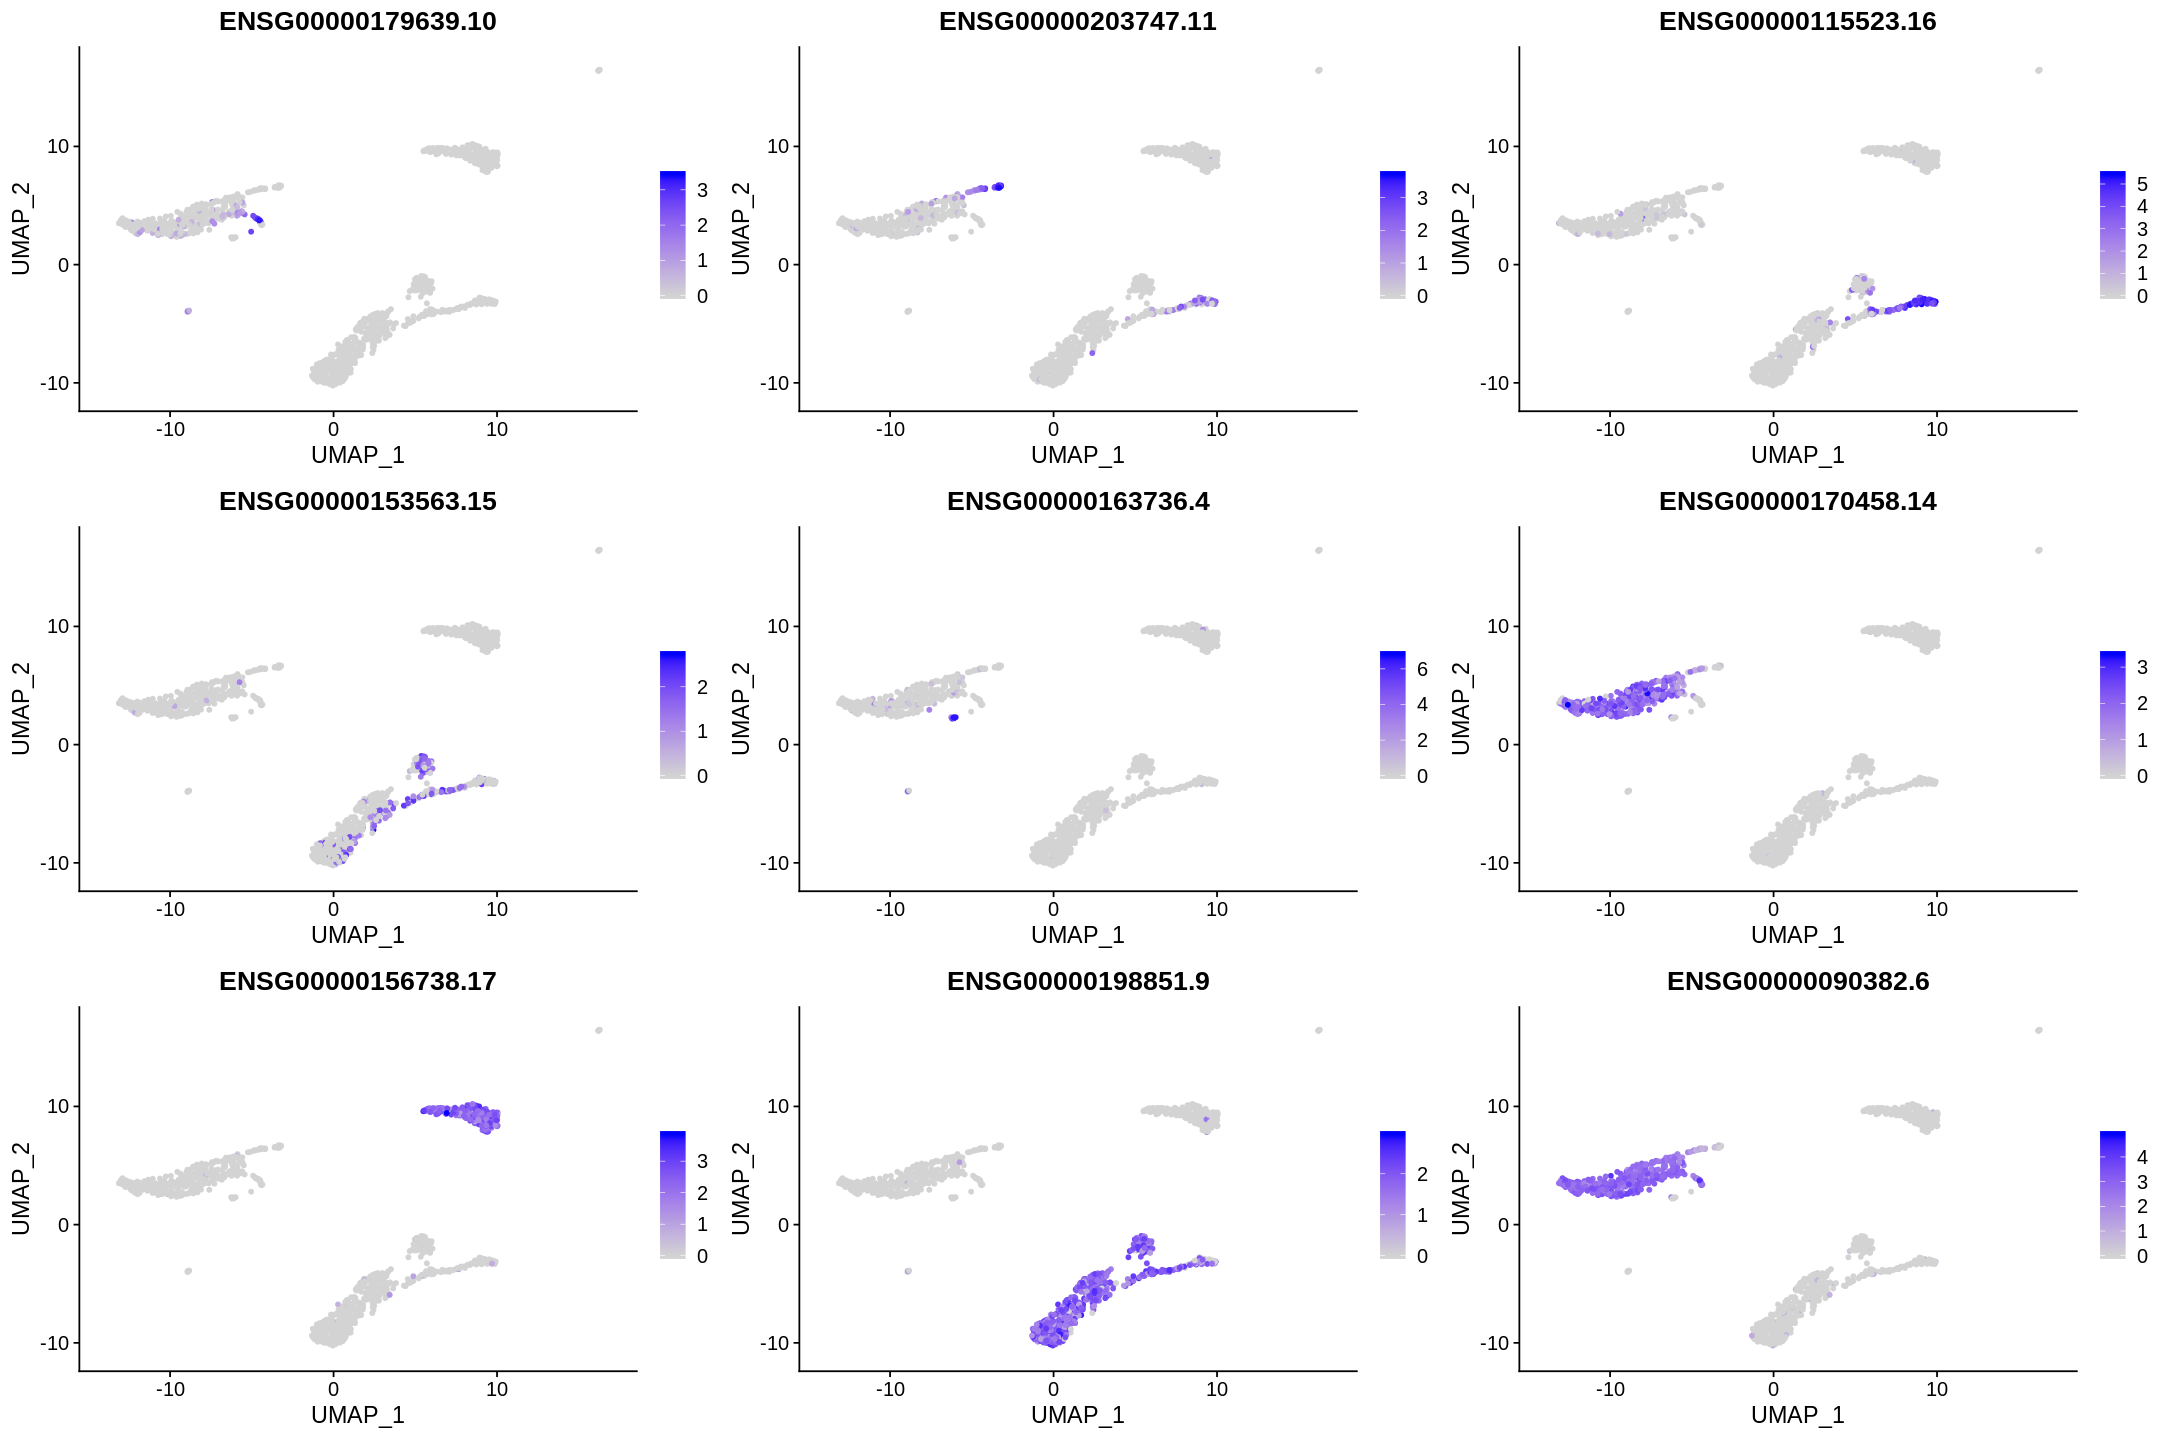

In [69]:
options(repr.plot.width=18, repr.plot.height=12)
FeaturePlot(pbmc, features = tr2g$gene[tr2g$gene_name %in% c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", 
    "CD8A")])

DoHeatmap generates an expression heatmap for given cells and features. In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

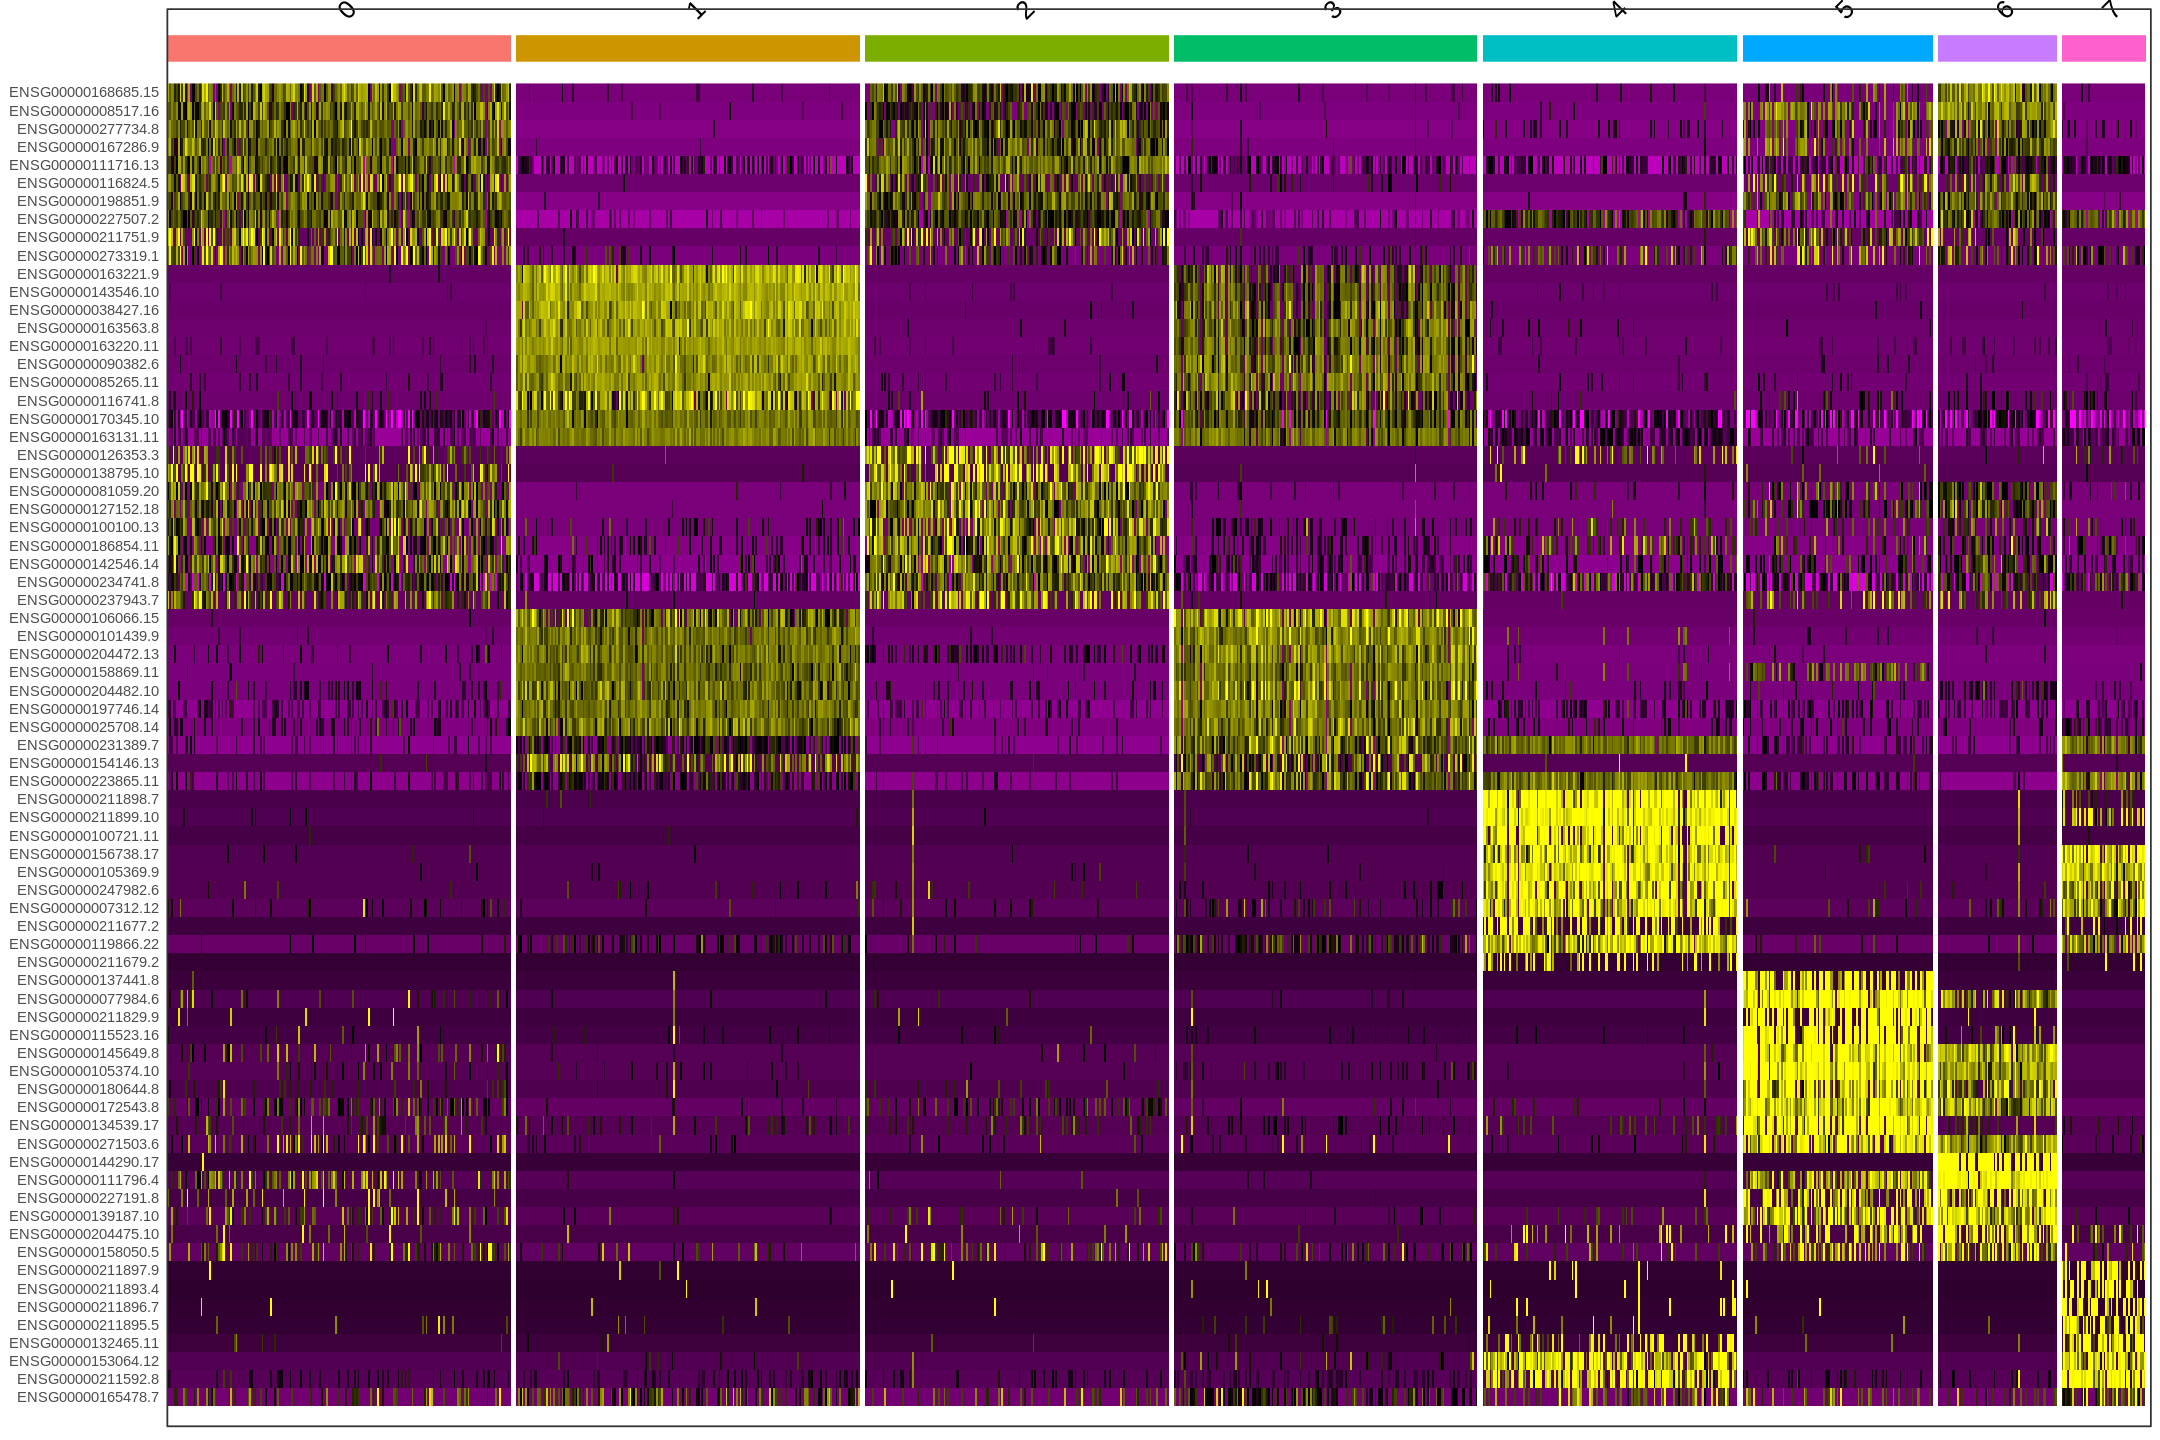

In [70]:
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

Assigning cell type identity to clusters
Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

Warning message:
“Cannot find identity NA”


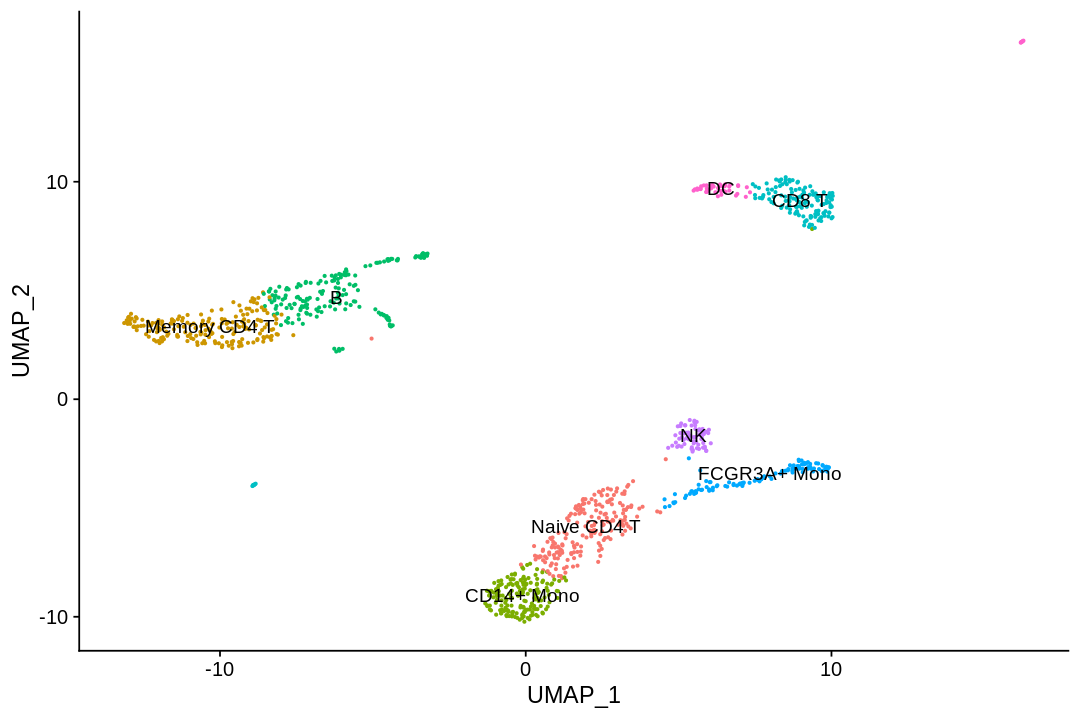

In [71]:
options(repr.plot.width=9, repr.plot.height=6)
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", 
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [0]:
system("date", intern=TRUE)

[1] "Thu Feb  6 08:21:53 UTC 2020"

In [0]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.4.0               stringr_1.4.0              
 [3] dplyr_0.8.3                 purrr_0.3.3                
 [5] readr_1.3.1                 tidyr_1.0.2                
 [7] tibble_2.1.3                ggplot2_3.2.1              
 [